# Digit Recognition using Deep Nets

We will try a working example on how to train a convolutional neural net. 

Once again, we use the MNIST dataset (see Tutorial 11 for more info) as a well studied digit recognition problem.

## Caffe

We use the Caffe framework (check out http://caffe.berkeleyvision.org/) as the API to create, train and test a convolutional neural net.

Caffe has has command line, Python, and MATLAB interfaces. We will be using the Caffe-python API, i.e. pycaffe, in this tutorial.

### Installing Caffe

To install Caffe, check out the installation guide on http://caffe.berkeleyvision.org/installation.html.

The Caffe pre-built binaries for windows is available on https://github.com/BVLC/caffe/tree/windows.

Download the pre-built binaries for "Visual Studio 2015, CPU only, Python 3.5" (if you have an nVidia GPU and CUDA 8.0 installed, you can download "Visual Studio 2015, CUDA 8.0, Python 3.5" binaries) and extract the arxive into a working directory (e.g. C:\caffe\).

Add the "bin" subdirectory (in our example, C:\caffe\bin) to the system path. This subdirectory contains all the required libraries and the in addition to caffe.exe.

Create an Environment Variable named "PYTHONPATH" (without the quotes) and set its value to the "python" subdirectory (i.e. C:\caffe\python).

Also, install the following Python packages:

conda install --yes numpy scipy matplotlib scikit-image pip six

conda install --yes --channel willyd protobuf==3.1.0

At this point, you should be able to "import caffe" on a Python terminal (or a jupyter notebook) without any errors.

In [1]:
import caffe

The Python interface – pycaffe – is the caffe module to load models, do forward and backward, handle IO, visualize networks, and even instrument model solving. All model data, derivatives, and parameters are exposed for reading and writing.

caffe.Net is the central interface for loading, configuring, and running models. caffe.Classifier and caffe.Detector provide convenience interfaces for common tasks.

caffe.SGDSolver exposes the solving interface.

caffe.io handles input / output with preprocessing and protocol buffers.

caffe.draw visualizes network architectures.

Caffe blobs (caffe internal data structure) are exposed as numpy ndarrays for ease-of-use and efficiency.

### Setting up Python modules

Set up the Python environment:

In [3]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn import cross_validation

### Preparing Data

Data enters Caffe through data layers: they lie at the bottom of nets. Data can come from efficient databases (LevelDB or LMDB), directly from memory, or from files on disk in HDF5 or common image formats.

Check out http://caffe.berkeleyvision.org/tutorial/layers.html for more info on each Data Layer.

To load data directly from memory, we should use the Memory Data Layer. This requires a source of contiguous data as a 4D row major array, which is read one batch-sized chunk at a time. 

To pass the data to the network, we should call net.set_input_arrays(imgData, labels); assuming that imgData is a (Nx1x28x28) and labels is a (Nx1x1x1) numpy float32 arrays.

So, let's write a helper class to load the MNIST training csv file and to split the training set (42000 training entries) into a training (90%) and a validation set (10%).

In [4]:
# A helper class to load the MNIST train/test data/label and to visualize them
class mnist:
    # We'll do everything in the class constructor routine
    # basedirectory: The directory containing train.csv
    def __init__(self,basedirectory):
        # our prior knowledge
        self.height = 28
        self.width = 28
        self.channels = 1
        
        # Read the whole csv file        
        with open(basedirectory+'train.csv', 'r') as csv_file:
            # read and discard the csv header row (first line)
            next(csv_file)
            # create a Python CSV object
            reader = csv.reader(csv_file)
            # read the whole csv into a single list
            csvdata = list(reader)
            # number of rows
            row_count = len(csvdata)
            
        # Create 4D imgData/labels numpy arrays for the training set
        # It's better to know the number of data samples 
        # before creating numpy arrays to avoid multiple memory copying
        imgData = np.zeros((row_count,self.channels,self.height,self.width),dtype='float32')
        labels = np.zeros((row_count,1,1,1),dtype='float32')
        
        for n in range(row_count):            
            # get the digit label
            labels[n,0,0,0] = csvdata[n][0]            
            # read and reshape the digit image
            pixels = csvdata[n][1:]
            # normalize the pixel intensities between [0,1]
            img = np.array(pixels, dtype='float32')/255.
            imgData[n,:,:,:] = img.reshape(self.channels,self.height,self.width)  
        
        # Split the training data into training and validation sets
        # We'll use the cross_validation from the sklearn module
        Xtrain,Xval,ytrain,yval = cross_validation.train_test_split(imgData,labels,test_size=0.1)
        # make the data public
        self.train_imgData = Xtrain
        self.train_labels = ytrain
        self.Ntrain = Xtrain.shape[0]
        self.val_imgData = Xval
        self.val_labels = yval
        self.Nval = Xval.shape[0]
        
        print("train_imgData.shape: ", self.train_imgData.shape)
        print("train_labels.shape:  ", self.train_labels.shape)
        print("val_imgData.shape:   ", self.val_imgData.shape)
        print("val_labels.shape: ", self.val_labels.shape)

In [5]:
# Load the MNIST dataset
# train_imgData and val_imgData are 4-D (Nx1x28x28) numpy arrays containing image data
# train_labels and val_labelsval are 4-D (Nx1x1x1) numpy arrays containing digit labels
Dataset = mnist('./')

train_imgData.shape:  (37800, 1, 28, 28)
train_labels.shape:   (37800, 1, 1, 1)
val_imgData.shape:    (4200, 1, 28, 28)
val_labels.shape:  (4200, 1, 1, 1)


### Creating the net

To create a Caffe model you need to define the model architecture in a protocol buffer definition file (a .prototxt file). The layers might be Data layers, Convolutional layers, Fully Connected layers, Pooling layers, Activation layers, Loss layers and utility layers.

In the net prototxt file, each layer is be named, its parameters are set and the layer's input/output are named too.


Now let's make a variant of LeNet, the classic 1989 convnet architecture.

![title](lenet_architecture.png)

We start by creating the net. We'll write the net in a succinct and natural way as Python code that serializes to Caffe's protobuf model format. Note that we can also manually create and write to the prototxt file directly using a text editor.

### Making Prototxt Nets with Python

In [6]:
from caffe import layers as L
from caffe import params as P

# A function to create a write the net prototxt
def lenet(batch_size):
    # NetSpec is a helper class in pycaffe to make Prototxt nets 
    n = caffe.NetSpec()    
    
    # The data layer. We use a MemoryData layer to read data directly from memory
    n.imgdata, n.label = L.MemoryData(batch_size=batch_size,channels=Dataset.channels,
                                      height=Dataset.height,width=Dataset.width,ntop=2)
    
    n.conv1 = L.Convolution(n.imgdata, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.fc1 =   L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.fc1, in_place=True)
    n.score = L.InnerProduct(n.relu1, num_output=10, weight_filler=dict(type='xavier'))
    n.loss =  L.SoftmaxWithLoss(n.score, n.label)
    
    return n.to_proto()
    
# Create a net prototxt for training lenet_train.prototxt   
with open('./lenet_train.prototxt', 'w') as f:
    f.write(str(lenet(40)))

# Create another net prototxt for testing lenet_test.prototxt       
with open('./lenet_test.prototxt', 'w') as f:
    f.write(str(lenet(42)))

The net has been written to disk in a more verbose but human-readable serialization format using Google's protobuf library. You can read, write, and modify this description directly. 

Let's take a look at the net prototxt.

In [7]:
f = open('lenet_train.prototxt', 'r')
print (f.read())
f.close()

layer {
  name: "imgdata"
  type: "MemoryData"
  top: "imgdata"
  top: "label"
  memory_data_param {
    batch_size: 40
    channels: 1
    height: 28
    width: 28
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "imgdata"
  top: "conv1"
  convolution_param {
    num_output: 20
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  convolution_param {
    num_output: 50
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool2"
  type: "Pooling"
  bottom: "conv2"
  top: "pool2"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "fc1"
  type: "InnerProduct"
  bottom: "pool2"
  top: "fc1"
  inner_product_param {
    num_output: 500
    weight_filler {
      type:

In addition to the net prototxt, we need another external file to help out.

We call this the solver prototxt, which defines the learning parameters.

In [8]:
f = open('lenet_solver.prototxt', 'r')
print (f.read())
f.close()

# The train/test net protocol buffer definition
train_net: "lenet_train.prototxt"
test_net: "lenet_test.prototxt"

# test_iter specifies how many forward passes the test should carry out.
# In the case of MNIST, we have test batch size 42 and 100 test iterations,
# covering the full 4200 validation images.
test_iter: 100
# Carry out testing every 500 training iterations.
test_interval: 500

# The base learning rate, momentum and the weight decay of the network.
base_lr: 0.01
momentum: 0.9
weight_decay: 0.0005
# The learning rate policy
lr_policy: "inv"
gamma: 0.0001
power: 0.75

# The maximum number of iterations
max_iter: 10000

# solver mode: CPU or GPU
solver_mode: CPU



### Solver

Let's pick a device (CPU, GPU0, GPU1, ...) and load the solver. 

We'll use Stochastic Gradient Descend (SGD) with momentum, but other methods are also available.

In [14]:
# Use the CPU
# caffe.set_mode_gpu(), caffe.set_device(0) if using a GPU
caffe.set_mode_cpu()

### load the solver and create train and test nets
solver = caffe.SGDSolver('lenet_solver.prototxt')

# Set the memory data variables
# train net
solver.net.set_input_arrays(Dataset.train_imgData,Dataset.train_labels)
# test net (there can be more than one)
solver.test_nets[0].set_input_arrays(Dataset.val_imgData,Dataset.val_labels)

To get an idea of the architecture of our net, we can check the dimensions of the intermediate features (blobs) and parameters (these will also be useful to refer to when manipulating data later)

In [9]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('imgdata', (40, 1, 28, 28)),
 ('label', (40,)),
 ('conv1', (40, 20, 24, 24)),
 ('pool1', (40, 20, 12, 12)),
 ('conv2', (40, 50, 8, 8)),
 ('pool2', (40, 50, 4, 4)),
 ('fc1', (40, 500)),
 ('score', (40, 10)),
 ('loss', ())]

In [10]:
# just print the weight sizes (we'll omit the biases)
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1', (20, 1, 5, 5)),
 ('conv2', (50, 20, 5, 5)),
 ('fc1', (500, 800)),
 ('score', (10, 500))]

Before taking off, let's check that everything is loaded as we expect. We'll run a forward pass on the train and test nets and check that they contain our data.

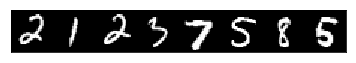

training labels:  [ 2.  1.  2.  3.  7.  5.  8.  5.]


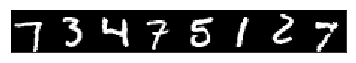

test labels:  [ 7.  3.  4.  7.  5.  1.  2.  7.]


In [94]:
# Do a forward pass on the train net
solver.net.forward()

# Display the first 8 training images/labels
plt.imshow(solver.net.blobs['imgdata'].data[0:8,0].transpose(1, 0, 2).reshape(28, 8*28),cmap='gray'),plt.xticks([]), plt.yticks([]),plt.show()
print('training labels: ',solver.net.blobs['label'].data[0:8,0,0,0])

# Do a forward pass on the test net
solver.test_nets[0].forward()

# Display the first 8 validation images/labels
plt.imshow(solver.test_nets[0].blobs['imgdata'].data[0:8,0].transpose(1, 0, 2).reshape(28, 8*28),cmap='gray'),plt.xticks([]), plt.yticks([]),plt.show()
print('test labels: ',solver.test_nets[0].blobs['label'].data[0:8,0,0,0])

### Stepping the solver

Let's take one step of (minibatch) SGD and see what happens.

In [95]:
solver.step(1)

Do we have gradients propagating through our filters? Let's see the updates to the first layer, shown here as a 4×5 grid of 5×5 filters.

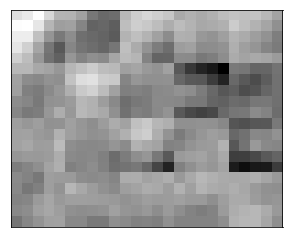

In [30]:
# Display the first training image
plt.imshow(solver.net.params['conv1'][0].diff[:,0].reshape(4, 5, 5, 5).transpose(0, 2, 1, 3).reshape(4*5, 5*5),cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

Something is happening.

###  Writing a training loop

Let's run the net for a while, keeping track of a few things as it goes. 

In [15]:
# Number of training iterations
niter = 200
# Test interval
test_interval = 25
# losses and accuracies
train_loss = np.zeros(niter)
test_acc = np.zeros(int(np.ceil(niter / test_interval)))
# We will also save the results on the first test batch
output = np.zeros((niter, 8, 10))

# the main solver loop
for it in range(niter):
    # A single SGD iteration (a minibatch) by Caffe
    solver.step(1)  
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='conv1')
    output[it] = solver.test_nets[0].blobs['score'].data[:8]
    
    # run a full test every so often
    if it % test_interval == 0:
        print('Iteration', it, 'testing...')
        correct = 0
        # number of test iterations to perform
        test_iter = 100
        for test_it in range(test_iter):
            # predict the digit label
            solver.test_nets[0].forward()
            # sum over all correct predictions
            # solver.test_nets[0].blobs['score'].data returns the likelihood of the digit label
            # solver.test_nets[0].blobs['score'].data.argmax(1) is the most probable label
            # summation is over all the digits in a single test batch (=42)
            correct += sum(solver.test_nets[0].blobs['score'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data[:,0,0,0])
        # Compute the test accuracy (42 is the test batch size)
        test_acc[it // test_interval] = correct / (test_iter*42)

Iteration 0 testing...
Iteration 25 testing...
Iteration 50 testing...
Iteration 75 testing...
Iteration 100 testing...
Iteration 125 testing...
Iteration 150 testing...
Iteration 175 testing...


Let's plot the train loss and test accuracy.

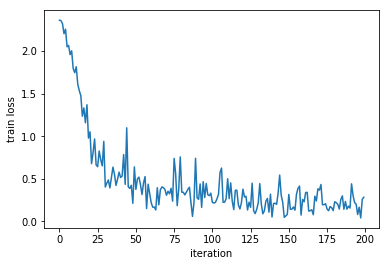

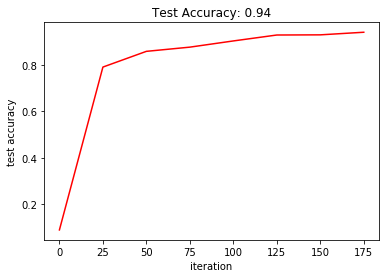

In [17]:
plt.plot(np.arange(niter),train_loss)
plt.xlabel('iteration')
plt.ylabel('train loss')
plt.show()

plt.plot(test_interval * np.arange(len(test_acc)), test_acc, 'r')
plt.xlabel('iteration')
plt.ylabel('test accuracy')
plt.title('Test Accuracy: {:.2f}'.format(test_acc[-1]))
plt.show()

The loss seems to have dropped quickly and coverged (except for stochasticity), while the accuracy rose correspondingly.

Since we saved the results on the first test batch, we can watch how our prediction scores evolved. We'll plot time on the x axis and each possible label on the y, with lightness indicating confidence.

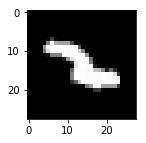

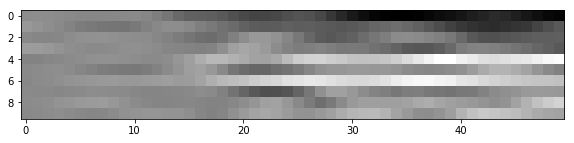

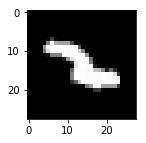

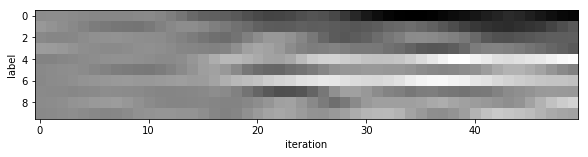

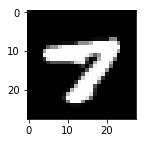

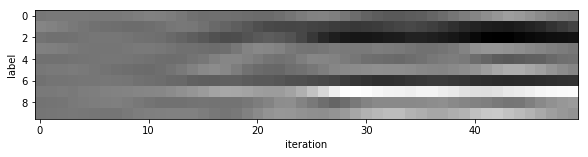

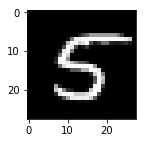

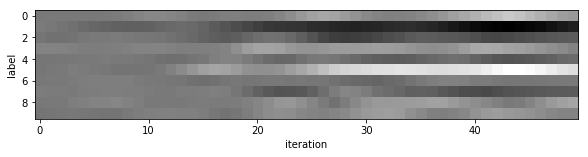

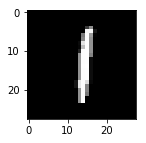

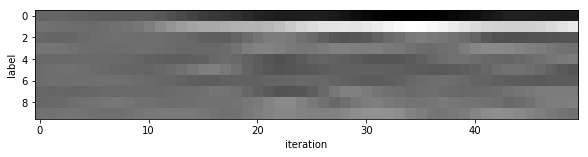

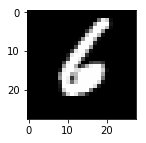

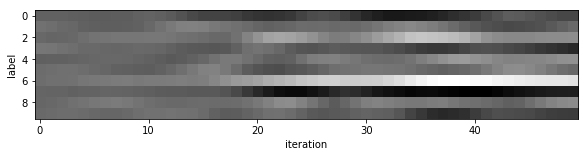

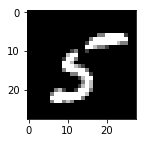

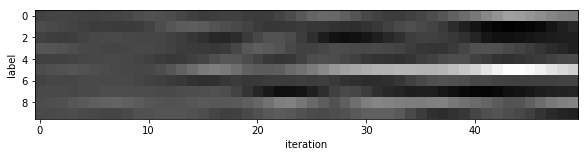

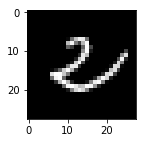

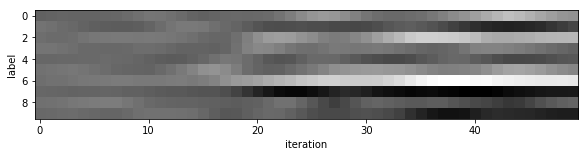

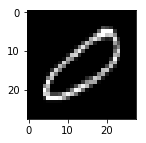

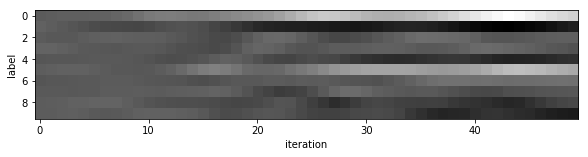

In [19]:
for i in range(8):
    plt.figure(figsize=(2, 2))
    plt.imshow(solver.test_nets[0].blobs['imgdata'].data[i, 0], cmap='gray')
    plt.figure(figsize=(10, 2))
    plt.imshow(output[:50, i].T, interpolation='nearest', cmap='gray')
    plt.xlabel('iteration')
    plt.ylabel('label')
    plt.show()